In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# List all directories in your Google Drive
import os
dataset_path = '/content/drive/My Drive'
print("Checking folder structure:")
print(os.listdir(dataset_path))


Checking folder structure:
['Untitled document (17).gdoc', 'Chap-05-Addressing (1) (1).ppt', 'Chap-11-Routing (1) (1).ppt', 'Untitled document (16).gdoc', 'csma.ppt', 'Module 3 (4) (1).pdf', 'WhatsApp Image 2024-04-01 at 13.22.38_2b577d1e.jpg', '22BCE1416_lab10.docx', 'Untitled document (15).gdoc', 'Untitled document (14).gdoc', 'KanishkSharma.pdf', 'Untitled document (13).gdoc', 'Untitled document (12).gdoc', 'Untitled document (11).gdoc', 'Colab Notebooks', 'Untitled document (10).gdoc', 'Untitled document (9).gdoc', 'Untitled document (8).gdoc', 'Untitled document (7).gdoc', 'Fire-Detection', 'fires.csv', 'anushka_machinecodeGen.docx', 'Untitled document (6).gdoc', 'data', 'Untitled document (5).gdoc', 'od.pdf', 'Modify Itinerary.pdf', 'Cryptography Lab 1.docx', 'Untitled document (4).gdoc', 'Untitled document (3).gdoc', 'DIGITAL ASSIGNMENT 1.docx', 'Untitled document (2).gdoc', 'Untitled document (1).gdoc', 'AES.docx', 'Untitled document.gdoc', 'apnea-ecg-database-1.0.0', 'Kanishk.

In [ ]:

!pip install tensorflow librosa numpy scikit-learn



In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Path to dataset folders
SNORING_PATH = '/content/drive/My Drive/SnoringDataset/1'
NON_SNORING_PATH = '/content/drive/My Drive/SnoringDataset/0'

# Enhanced Data Augmentation
def augment_audio(y, sr):
    """Augment audio with time stretching, pitch shifting, and noise addition"""
    y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.8, 1.2))  # Random stretch
    y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.randint(-3, 3))  # Random pitch shift
    noise = np.random.randn(len(y)) * 0.005  # Add slight noise
    y = y + noise
    return y, sr

# Extract Mel Spectrogram
def extract_mel_spectrogram(audio_file, augment=False):
    """Extract Mel spectrogram with optional augmentation"""
    y, sr = librosa.load(audio_file, sr=None)

    if augment:
        y, sr = augment_audio(y, sr)

    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram.T  # Shape: (time_steps, n_mels)

# Prepare Dataset
def prepare_data(augment=False, target_length=130):
    """Load and preprocess dataset"""
    X, y = [], []

    for path, label in [(SNORING_PATH, 1), (NON_SNORING_PATH, 0)]:
        for filename in os.listdir(path):
            if filename.endswith(".wav"):
                audio_file = os.path.join(path, filename)
                mel_spec = extract_mel_spectrogram(audio_file, augment)

                # Pad/truncate to target length
                if mel_spec.shape[0] < target_length:
                    pad_width = ((0, target_length - mel_spec.shape[0]), (0, 0))
                    mel_spec = np.pad(mel_spec, pad_width, mode='constant')
                else:
                    mel_spec = mel_spec[:target_length, :]

                X.append(mel_spec)
                y.append(label)

    X = np.array(X)
    X = np.expand_dims(X, -1)  # Add channel dimension
    y = np.array(y)

    return X, y

# Load Data with Augmentation
X, y = prepare_data(augment=True)

# Fix Train-Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print Class Distribution
print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))

# Model Architecture with Reduced Complexity
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Reshape((14, 14*128)),  # Adjusted for fewer filters
        layers.Bidirectional(layers.LSTM(64, return_sequences=False)),  # Reduced LSTM units

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.6),  # Increased dropout
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create Model
model = create_model(X_train.shape[1:])

# Train with Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Make Predictions
y_pred_probs = model.predict(X_test)
y_pred_binary = (y_pred_probs > 0.5).astype(int)  # Convert to binary

# Print Predicted Probabilities
print("\nPredicted Probability Values:")
print(y_pred_probs[:10])  # Show first 10 predictions

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"\nPrecision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Train class distribution: [400 400]
Test class distribution: [100 100]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.7170 - loss: 0.5467 - val_accuracy: 0.5250 - val_loss: 0.8943
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9510 - loss: 0.2080 - val_accuracy: 0.5050 - val_loss: 1.1285
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9644 - loss: 0.1314 - val_accuracy: 0.5450 - val_loss: 0.9806
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9799 - loss: 0.0823 - val_accuracy: 0.5900 - val_loss: 0.9769
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9826 - loss: 0.0598 - val_accuracy: 0.6150 - val_loss: 0.7067
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9934 - loss: 0.0462 - val_accuracy: 0.6250 - val_loss: 1.4502
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9989 - loss: 0.0088 - val_accuracy: 0.6700 - val_loss: 1.0466
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9647 - loss: 0.0740 - val_accuracy: 0.7400 - v

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = model.predict(X_test)

# # Convert probabilities to binary values (0 or 1)
# y_pred_binary = (y_pred > 0.5).astype(int)  # Fix: Define y_pred_binary

# Print predicted probability values
print("Predicted Probability Values:")
formatted_probs = np.round(y_pred.flatten(), 2)  # Round to 2 decimal places
print(formatted_probs)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

# Evaluate the model again
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Probability Values:
[1.   0.   0.   0.   1.   0.99 1.   1.   0.   0.   0.99 1.   1.   0.
 0.   0.   1.   0.   1.   0.   1.   0.   1.   0.   1.   1.   1.   1.
 0.   1.   0.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   1.
 1.   0.   0.   1.   0.   1.   1.   0.   0.98 0.   0.99 0.01 0.   0.
 1.   0.   0.   1.   1.   1.   0.99 0.   0.   0.   1.   0.99 0.   0.
 0.   0.   1.   1.   1.   1.   0.   0.   1.   0.   0.   0.93 1.   1.
 0.77 0.   0.   0.   0.   0.   1.   1.   0.96 0.   0.   1.   1.   0.
 1.   0.   1.   0.   0.   1.   1.   0.99 0.   1.   0.   0.99 1.   1.
 0.   1.   0.   0.   0.68 1.   0.   0.   0.   1.   0.   1.   0.   0.
 0.01 0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
 0.99 1.   0.   0.   1.   0.   0.   1.   1.   0.   0.   0.   1.   1.
 1.   0.   1.   0.98 0.   0.   1.   1.   1.   0.   1.   0.99 1.   0.
 0.08 0.   0.   0.   1.   0.   0.95 0.32 0.   0.   0.   1.   0.99 0.
 1.   0.   1.   1.   1.   0.43 1.  

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


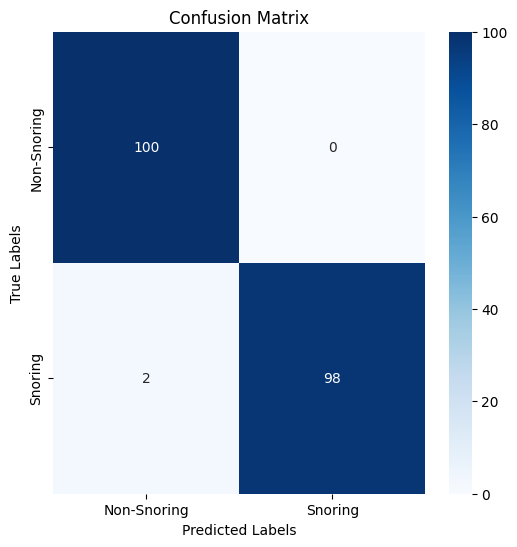

Classification Report:
              precision    recall  f1-score   support

 Non-Snoring       0.98      1.00      0.99       100
     Snoring       1.00      0.98      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



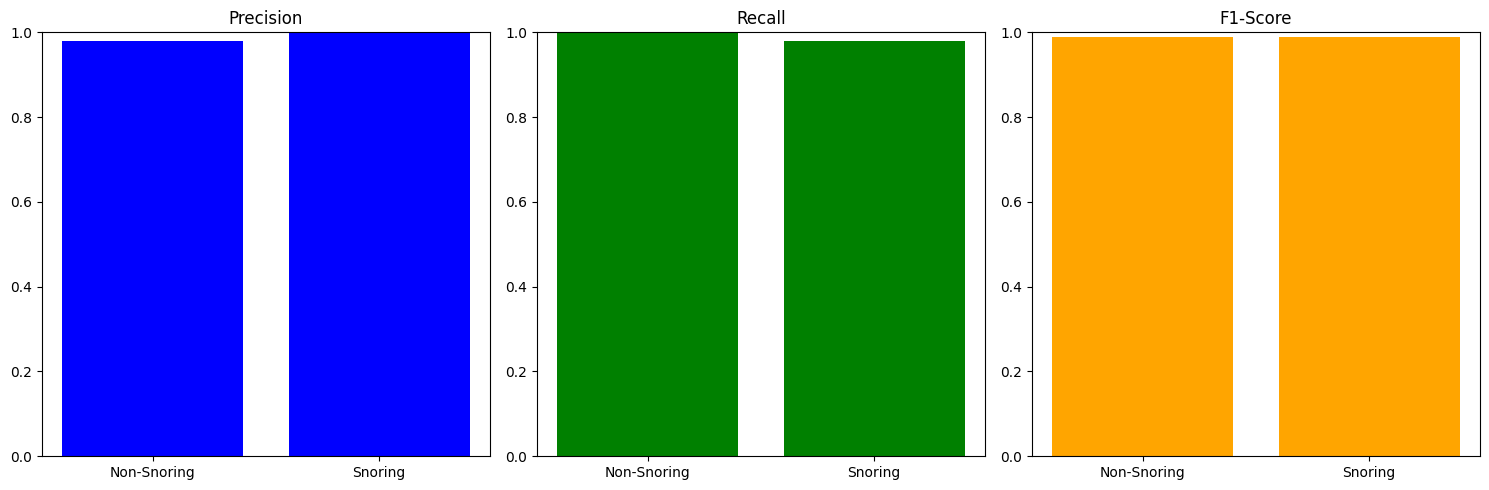

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


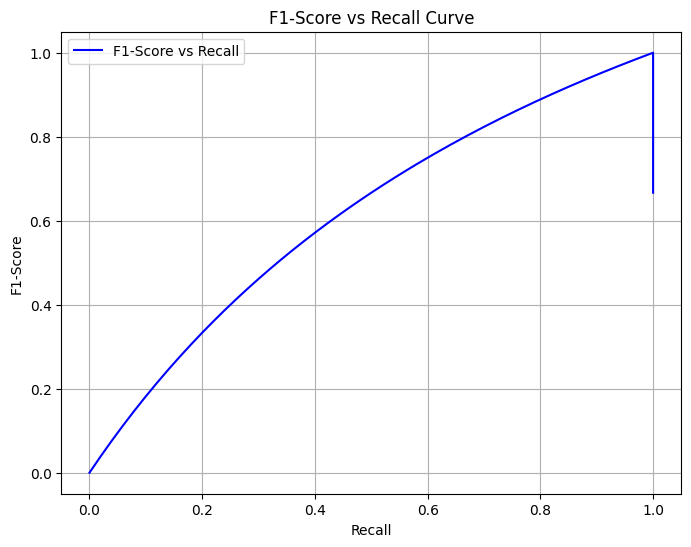

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# After predicting on the test set

# Predict on the test set
y_pred = model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

# Use probability threshold only for confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Snoring', 'Snoring'], yticklabels=['Non-Snoring', 'Snoring'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred_binary, target_names=['Non-Snoring', 'Snoring'])

# Print Classification Report
print("Classification Report:")
print(report)

# Optionally, you can also plot precision, recall, and f1-score using bar charts:

# Extract metrics from the classification report
metrics = classification_report(y_test, y_pred_binary, output_dict=True)

# Adjust to use the correct keys (0 for Non-Snoring, 1 for Snoring)
precision = [metrics['0']['precision'], metrics['1']['precision']]
recall = [metrics['0']['recall'], metrics['1']['recall']]
f1_score = [metrics['0']['f1-score'], metrics['1']['f1-score']]

# Plot Bar Charts for Precision, Recall, and F1-Score
labels = ['Non-Snoring', 'Snoring']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision
axes[0].bar(labels, precision, color='blue')
axes[0].set_title('Precision')
axes[0].set_ylim(0, 1)

# Recall
axes[1].bar(labels, recall, color='green')
axes[1].set_title('Recall')
axes[1].set_ylim(0, 1)

# F1-Score
axes[2].bar(labels, f1_score, color='orange')
axes[2].set_title('F1-Score')
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

from sklearn.metrics import f1_score, recall_score, precision_recall_curve
import matplotlib.pyplot as plt

# Get predicted probabilities from the model
y_pred_prob = model.predict(X_test)

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Calculate F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Plot F1-Score vs Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, f1_scores, color='blue', label='F1-Score vs Recall')
plt.title('F1-Score vs Recall Curve')
plt.xlabel('Recall')
plt.ylabel('F1-Score')
plt.grid(True)
plt.legend()
plt.show()
